## Incorporating the Reimannian metric A in optimization
Requires an optimization method that can take a Hessian or a Hessian-Product as input.

[SciPy Optimize Reference](http://docs.scipy.org/doc/scipy-0.14.0/reference/tutorial/optimize.html)

In [1]:
import numpy as np
import scipy.optimize

In [35]:
class Sphere(object):
    def __init__(self, x, r):
        self.x = x
        self.r = r
    def sdf(self, p):
        return np.linalg.norm(p - self.x) - self.r
    def sdfgrad(self, p):
        import warnings
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                grad = (p - self.x)/np.linalg.norm(p - self.x)
            except Warning as e:
                grad = np.zeros(p.shape)
        return grad
            
class SphereSDF(object):
    def __init__(self, spheres):
        self.spheres = spheres
    def sdf(self, p):
        return np.min([s.sdf(p) for s in self.spheres])
    def sdfgrad(self, p):
        i = np.argmin([s.sdf(p) for s in self.spheres])
        return self.spheres[i].sdfgrad(p)

In [92]:
spheres = [Sphere(np.asarray([0.25, 0.25]), 0.25)]
spheres.append(Sphere(np.asarray([0.75, 0.75]), 0.25))
sdf = SphereSDF(spheres)

In [93]:
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

<matplotlib.colorbar.Colorbar instance at 0x10bad77e8>

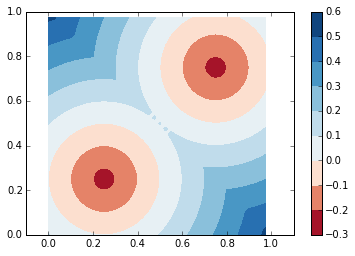

In [94]:
delta = 0.025
x = np.arange(0, 1.0, delta)
y = np.arange(0, 1.0, delta)
X, Y = np.meshgrid(x, y)
pts = np.vstack((X.flatten(), Y.flatten())).T
Z = np.asarray([sdf.sdf(p) for p in pts])
Z = Z.reshape(X.shape)
norm = MidpointNormalize(midpoint=0.)
CS = plt.contourf(X, Y, Z, norm=norm, cmap=plt.cm.RdBu)
plt.axis('equal')
plt.colorbar()

In [2]:
def unflat(x, ndim, xs, xt):
    xall = x.reshape(x.shape[0]/ndim,ndim)
    return np.vstack((xs, xall, xt))

def flat(x):
    return x.flatten()

def optimize(xs, xt, x0=None, npts=10):
    '''
    Functional gradient optimization
    @param xs - fixed start configuration
    @param xt - fixed target configuration
    @param x0 - inital seed for waypoints
    @param npts - number of waypoints    
    @return res - SciPy dict of optimization result
    @return xall - (numIter x npts) iterations
    '''
    ndim = xs.shape[0]
    if x0 is None:
        x0 = np.random.rand(npts, ndim)
    npts = x0.shape[0]
    hess = np.diag([2]*npts*ndim)
    rows = np.arange(0, npts*ndim-ndim)
    cols = np.arange(ndim, npts*ndim)
    hess[rows, cols] = -1
    hess[cols, rows] = -1
    def fn(x):
        traj = unflat(x, ndim, xs, xt)
        return 0.5*np.sum([np.linalg.norm(traj[i,:] - traj[i-1,:])**2 for i in range(1, npts+2)])
    def jac(x):
        traj = unflat(x, ndim, xs, xt)
        grad = 2*traj[1:-1,:] - traj[2:,:] - traj[0:-2,:]
        return flat(grad)
    def hessian(x):
        return hess
    xall = []
    def fn_call(x):
        xall.append(x)    
    res = scipy.optimize.minimize(fn, flat(x0), method='Newton-CG', jac=jac, hess=hessian, callback=fn_call)
    return res, np.asarray(xall)

In [3]:
def animate_traj(xall, fname='traj.mp4'):
    fig = plt.figure()
    def update(i):
        traj = unflat(xall[i, :], ndim, xs, xt)
        plt.cla()
        plt.axis([-0.2, 1.2, -0.2, 1.2])
        return plt.plot(traj[:, 0], traj[:, 1], 'ro-')
    ani = animation.FuncAnimation(fig, update, frames=range(xall.shape[0]))
    ani.save(fname)
    return ani

In [4]:
ndim = 2
xs = np.zeros(ndim)
xt = np.ones(ndim)
res, xall = optimize(xs, xt, x0=None)
print res['message']
print 'Evals:', res['njev'], '+', res['nfev'], '+', res['nhev'], '=', res['njev'] + res['nfev'] + res['nhev']

Optimization terminated successfully.
Evals: 16 + 9 + 8 = 33


[-0.2, 1.2, -0.2, 1.2]

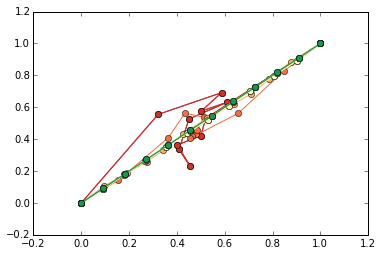

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
numplot = 10.
mycm = cm.RdYlGn
for j, i in enumerate(np.linspace(0, xall.shape[0]-1, numplot, dtype=np.int64)):
    traj = unflat(xall[i, :], ndim, xs, xt)
    im = plt.plot(traj[:, 0], traj[:, 1], 'o-', color=mycm(j/numplot))
plt.axis([-0.2, 1.2, -0.2, 1.2])

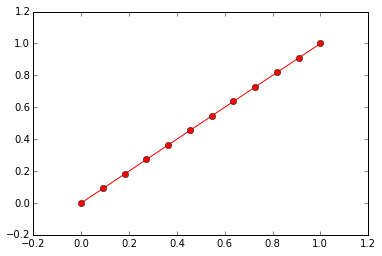

In [6]:
ani = animate_traj(xall)